In [11]:
from collections import namedtuple

import casadi as ca
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML, display

In [34]:
# Constants
nq = 7 
nv = 3
nu = 8 # 4 ground reaction forces + 4 joint velocities
g = 9.81
mu = 0.8 # default coefficient of friction for general simulations

# User preferences
trajectory_line = True
fixed_ground = False
grf = True
timer = True
save_gifs = False


# Physical parameters
m = 32.7  # kg boston dynamic's spot
L = 1.1  # body length (m)
h = 0.1 # body heigh (m) - ideally 0.2
I_z = 1 / 12 * m * (L**2 + h**2)  # moment of inertia for rectangular body around the z-axis 

leg_length = 0.3  # m - ideally 0.3-0.35

ForwardKinematicsPosition = namedtuple(
    "ForwardKinematicsPosition",
    [
        "CoM_x",
        "CoM_y",
        "front_shoulder_x",
        "front_shoulder_y",
        "front_knee_x",
        "front_knee_y",
        "front_ankle_x",
        "front_ankle_y",
        "rear_shoulder_x",
        "rear_shoulder_y",
        "rear_knee_x",
        "rear_knee_y",
        "rear_ankle_x",
        "rear_ankle_y",
    ], 
) 


def forward_kinematics(q):
    """
    Computes the 2D forward kinematics for a planar quadruped robot.

    Given the configuration vector `q`, this function calculates the positions
    of the shoulder, knee, and ankle joints for both the front and rear legs,
    based on the body position, orientation, and joint angles.

    Parameters:
    -----------
    q : array-like (length = 7)
        The configuration vector representing the robot's pose:
        q[0] = CoM_x      # Center of mass x-position
        q[1] = CoM_y      # Center of mass y-position
        q[2] = phi        # Orientation angle of the body
        q[3] = q_front_1  # Front leg upper joint angle
        q[4] = q_front_2  # Front leg lower joint angle
        q[5] = q_rear_1   # Rear leg upper joint angle
        q[6] = q_rear_2   # Rear leg lower joint angle

    Returns:
    --------
    ForwardKinematicsPosition
        A data object containing:
        - CoM_x, CoM_y
        - front_shoulder_x, front_shoulder_y
        - front_knee_x, front_knee_y
        - front_ankle_x, front_ankle_y
        - rear_shoulder_x, rear_shoulder_y
        - rear_knee_x, rear_knee_y
        - rear_ankle_x, rear_ankle_y

    Notes:
    ------
    This function assumes a 2-link leg model (hip and knee) for each of the front and rear legs.
    The body orientation phi defines the rotation of the body in world frame.
    Each leg is offset from the center of mass by ±L/2 along the body axis.
    """
    
    lib = ca
    if isinstance(q, np.ndarray):
        lib = np

    joint_positions = dict()
    joint_positions["CoM_x"] = q[0]
    joint_positions["CoM_y"] = q[1]

    phi = q[2]

    # Front leg
    theta1_front = q[3]
    theta2_front = q[4]

    front_shoulder_x = joint_positions["CoM_x"] + L / 2 * lib.cos(phi)
    front_shoulder_y = joint_positions["CoM_y"] + L / 2 * lib.sin(phi)

    front_knee_x = front_shoulder_x + leg_length * lib.cos(phi - lib.pi / 2 + theta1_front)
    front_knee_y = front_shoulder_y + leg_length * lib.sin(phi - lib.pi / 2 + theta1_front)

    front_ankle_x = front_knee_x + leg_length * lib.cos(phi - lib.pi / 2 + theta1_front + theta2_front)
    front_ankle_y = front_knee_y + leg_length * lib.sin(phi - lib.pi / 2 + theta1_front + theta2_front)

    joint_positions["front_shoulder_x"] = front_shoulder_x
    joint_positions["front_shoulder_y"] = front_shoulder_y
    joint_positions["front_knee_x"] = front_knee_x
    joint_positions["front_knee_y"] = front_knee_y
    joint_positions["front_ankle_x"] = front_ankle_x
    joint_positions["front_ankle_y"] = front_ankle_y

    # Rear leg
    theta1_rear = q[5]
    theta2_rear = q[6]

    rear_shoulder_x = joint_positions["CoM_x"] + -L / 2 * lib.cos(phi)
    rear_shoulder_y = joint_positions["CoM_y"] + -L / 2 * lib.sin(phi)

    rear_knee_x = rear_shoulder_x + leg_length * lib.cos(phi - lib.pi / 2 + theta1_rear)
    rear_knee_y = rear_shoulder_y + leg_length * lib.sin(phi - lib.pi / 2 + theta1_rear)

    rear_ankle_x = rear_knee_x + leg_length * lib.cos(phi - lib.pi / 2 + theta1_rear + theta2_rear)
    rear_ankle_y = rear_knee_y + leg_length * lib.sin(phi - lib.pi / 2 + theta1_rear + theta2_rear)

    joint_positions["rear_shoulder_x"] = rear_shoulder_x
    joint_positions["rear_shoulder_y"] = rear_shoulder_y
    joint_positions["rear_knee_x"] = rear_knee_x
    joint_positions["rear_knee_y"] = rear_knee_y
    joint_positions["rear_ankle_x"] = rear_ankle_x
    joint_positions["rear_ankle_y"] = rear_ankle_y

    return ForwardKinematicsPosition(**joint_positions)

def euler_integrate(q, v, u, dt):
    """
    Performs one Euler integration step for the planar quadruped's dynamics.

    This function updates the robot's generalized coordinates and velocities
    over a time step `dt` using current joint states, body velocity, and control input.
    It uses Newton-Euler dynamics to compute linear and angular accelerations from
    ground contact forces and integrates all values using the first-order Euler method.

    Parameters
    ----------
    q : np.ndarray
        Generalized coordinates of the robot (length 7):
        [x, y, phi, theta1, theta2, theta3, theta4], where:
        - (x, y): Center of mass position
        - phi: Body orientation angle (radians)
        - theta1, theta2: Front leg joint angles
        - theta3, theta4: Rear leg joint angles

    v : np.ndarray
        Generalized velocity of the robot (length 3):
        [vx, vy, omega], where:
        - vx, vy: Linear velocities of the center of mass
        - omega: Angular velocity (yaw rate)

    u : np.ndarray
        Control input vector, (forces/torques)(length 8):
        [GRF1_x, GRF1_y, GRF2_x, GRF2_y, dtheta1, dtheta2, dtheta3, dtheta4], where:
        - GRF1_x, GRF1_y: Ground reaction force on front foot
        - GRF2_x, GRF2_y: Ground reaction force on rear foot
        - dtheta1 to dtheta4: Joint angular velocities

    dt : float
        Time step size for Euler integration.

    Returns
    -------
    q_next : np.ndarray
        Updated generalized coordinates after time step `dt`.

    v_next : np.ndarray
        Updated velocity vector after time step `dt`.

    Notes
    -----
    - Uses simple Euler integration: `x_new = x + dx * dt`
    - Gravity is included in vertical acceleration
    - Rotational dynamics calculated using torque = r x F
    - Forward kinematics is used to get foot positions for torque computation
    """
    # Variables
    x, y, phi = q[0], q[1], q[2] # positions
    vx, vy, omega = v[0], v[1], v[2] # velocities
    theta1, theta2, theta3, theta4 = q[3], q[4], q[5], q[6] # joint angles
    dtheta1, dtheta2, dtheta3, dtheta4 = u[4], u[5], u[6], u[7] # angular velocities for joints
    GRF1_x, GRF1_y, GRF2_x, GRF2_y = u[0], u[1], u[2], u[3] # ground reaction forces

    # Integrate for positions
    x_next = x + vx * dt
    y_next = y + vy * dt
    phi_next = phi + omega * dt

    # Integrate for joint angles
    theta1_next = theta1 + dtheta1 * dt
    theta2_next = theta2 + dtheta2 * dt
    theta3_next = theta3 + dtheta3 * dt
    theta4_next = theta4 + dtheta4 * dt

    # Translational acceleration using newton's law
    ax = (GRF1_x + GRF2_x) / m
    ay = (GRF1_y + GRF2_y) / m - g 

    fk = forward_kinematics(q)

    # Compute position of the feet relative to the CoM
    rfront_x = fk.front_ankle_x - fk[0]
    rfront_y = fk.front_ankle_y - fk[1]
    rrear_x = fk.rear_ankle_x - fk[0]
    rrear_y = fk.rear_ankle_y - fk[1]

    # net torque from the point force, GRF1 and FRF2.
    torque = (-GRF1_x * rfront_y + GRF1_y * rfront_x) + (-GRF2_x * rrear_y + GRF2_y * rrear_x)
    # angular acc
    alpha = torque / I_z

    vx_next = vx + ax * dt
    vy_next = vy + ay * dt
    omega_next = omega + alpha * dt # angular acceleration of the body caused by external torques from the foot-ground forces (?)

    q_next = np.array([x_next, y_next, phi_next, theta1_next, theta2_next, theta3_next, theta4_next])
    v_next = np.array([vx_next, vy_next, omega_next])

    return q_next, v_next


class QuadrupedSimulator:
    def __init__(this, L, leg_length, figax=None):
        this.L = L
        this.leg_length = leg_length
        this.h = h

        # Initialize the plot and axis
        if figax is None:
            this.fig, this.ax = plt.subplots()
        else:
            this.fig, this.ax = figax
        
        # Set plot appearance such size and orientn.
        this.ax.set_aspect("equal")
        this.ax.set_xlim(-2.0, 4.5)
        this.ax.set_ylim(-1.0, 4.0)

        # Draw plot elements
        # (this.com_plot,) = this.ax.plot([], [], "g", markersize=3, label="CoM")
        # (this.shoulder_plots,) = this.ax.plot([], [], "bo", markersize=3, label="Shoulders")
        # (this.knee_plots,) = this.ax.plot([], [], "bo", markersize=3, label="Knees")
        # (this.ankle_plots,) = this.ax.plot([], [], "bo", markersize=3, label="Ankles")
        # (this.link_lines_front,) = this.ax.plot([], [], "#00FF00", linewidth=2)
        # (this.link_lines_rear,) = this.ax.plot([], [], "#00FF00", linewidth=2)
        # (this.force_lines_front,) = this.ax.plot([], [], "r-", linewidth=2)
        # (this.force_lines_rear,) = this.ax.plot([], [], "r-", linewidth=2)
        # (this.q_trajectory,) = this.ax.plot([], [], "k--", lw=1, alpha=0.5)

        # Rectangle for body
        this.body_patch = patches.Polygon([[0, 0], [0, 0], [0, 0], [0, 0]], closed=True, color="#5FB257", alpha=0.5)
        this.ax.add_patch(this.body_patch)

        # CoM marker
        (this.com_plot,) = this.ax.plot([], [], "ko", markersize=3, label="CoM")

        # Joint markers
        (this.shoulder_plots,) = this.ax.plot([], [], "o", markersize=3, markerfacecolor='white', markeredgecolor='blue')
        (this.knee_plots,) = this.ax.plot([], [], "o", markersize=3, markerfacecolor='white', markeredgecolor='blue')
        (this.ankle_plots,) = this.ax.plot([], [], "o", markersize=3, markerfacecolor='white', markeredgecolor='blue')

        # Leg lines
        (this.link_lines_front,) = this.ax.plot([], [], "k-", linewidth=2)
        (this.link_lines_rear,) = this.ax.plot([], [], "k-", linewidth=2)

        # GRFs
        if grf:
            (this.force_lines_front,) = this.ax.plot([], [], "r-", linewidth=1)
            (this.force_lines_rear,) = this.ax.plot([], [], "r-", linewidth=1)

        # Trajectory line
        if trajectory_line:
            (this.q_trajectory,) = this.ax.plot([], [], "k--", lw=1, alpha=0.5)

        # Draw ground line
        this.ax.plot([-3.0, 5.0], [0, 0], "k-", linewidth=1)

        # Timer
        if timer:
            this.timer_text = this.ax.text(
                0.5, 1.02,                  # x and y in axis coordinates (top-center, a bit above)
                "Time: 0.00 s",             # Initial text
                transform=this.ax.transAxes,
                ha="center", va="bottom", fontsize=10, color="black", fontweight="bold"
            )

        if fixed_ground: 
            x_start = -3.0
            x_end = 5.0
            spacing = 0.2
            length = 0.2
            x_vals = np.arange(x_start, x_end, spacing)
            for x in x_vals:
                this.ax.plot([x + length, x], [-0.01, -0.05 - length], "k-", linewidth=1)

    def set_data(this, q, u=None, q_trajectory=None, time=None):

        # This manual calibration of this local dependency is no longer used due to redundancy reason.
        # Robot coordinates
        # CoM_x, CoM_y, phi = q[0], q[1], q[2]
        # theta1, theta2, theta3, theta4 = q[3], q[4], q[5], q[6]

        fk = forward_kinematics(q)

        # === Update body polygon ===
        cx, cy, phi = fk.CoM_x, fk.CoM_y, q[2]
        L = this.L
        h = this.h

        # Define local corners (rectangle centered at origin)
        half_L = L / 2
        half_h = h / 2
        corners = np.array([
            [-half_L, -half_h],
            [ half_L, -half_h],
            [ half_L,  half_h],
            [-half_L,  half_h]
        ])

        # Rotate and translate to CoM
        rot = np.array([
            [np.cos(phi), -np.sin(phi)],
            [np.sin(phi),  np.cos(phi)]
        ])
        rotated_corners = corners @ rot.T + np.array([cx, cy])

        # Update polygon shape (just this line is enough)
        this.body_patch.set_xy(rotated_corners)

        this.com_plot.set_data([fk.CoM_x], [fk.CoM_y])

        this.shoulder_plots.set_data(
            [fk.front_shoulder_x, fk.rear_shoulder_x],
            [fk.front_shoulder_y, fk.rear_shoulder_y]
        )
        this.knee_plots.set_data(
            [fk.front_knee_x, fk.rear_knee_x],
            [fk.front_knee_y, fk.rear_knee_y]
        )
        this.ankle_plots.set_data(
            [fk.front_ankle_x, fk.rear_ankle_x],
            [fk.front_ankle_y, fk.rear_ankle_y]
        )
        # Shoulder → Knee → Ankle for both legs
        this.link_lines_front.set_data(
            [fk.front_shoulder_x, fk.front_knee_x, fk.front_ankle_x],
            [fk.front_shoulder_y, fk.front_knee_y, fk.front_ankle_y]
        )
        this.link_lines_rear.set_data(
            [fk.rear_shoulder_x, fk.rear_knee_x, fk.rear_ankle_x],
            [fk.rear_shoulder_y, fk.rear_knee_y, fk.rear_ankle_y]
        )
        if u is not None:

            force_scale = 1/250
            GRF1_x, GRF1_y, GRF2_x, GRF2_y = u[:4] * force_scale

            if grf:
                this.force_lines_front.set_data(
                    [fk.front_ankle_x, fk.front_ankle_x + GRF1_x],
                    [fk.front_ankle_y, fk.front_ankle_y + GRF1_y]
                )
                this.force_lines_rear.set_data(
                    [fk.rear_ankle_x, fk.rear_ankle_x + GRF2_x],
                    [fk.rear_ankle_y, fk.rear_ankle_y + GRF2_y]
                )

        if q_trajectory is not None:
            x_traj, y_traj = q_trajectory[0], q_trajectory[1]
            
            if trajectory_line:
                this.q_trajectory.set_data(x_traj, y_traj)
        
        if timer: 
            if time is not None:
                this.timer_text.set_text(f"Time: {time:.2f} s")

        plt.draw()

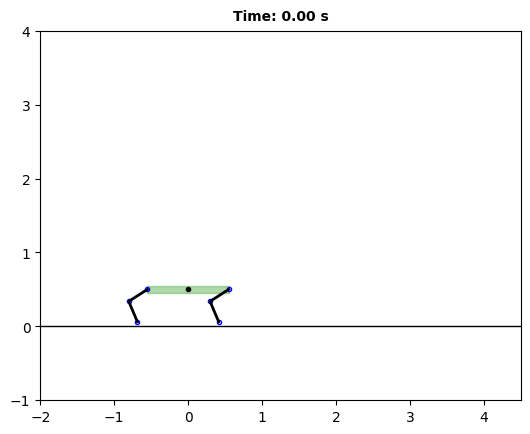

In [41]:
# Create state vector [x, y, phi, theta1-4]
q_initial = np.array([0.0, 0.5, 0, -1, 1.4, -1, +1.4])
v_initial = np.array([0, 0, 0])

# Forward jump
q_final = np.array([2.25, 0.5, 0, -1, 1.4, -1, +1.4])
v_final = np.array([0, 0, 0])

# Backflip
# q_final = np.array([1.7, 1.0, 2 * np.pi, -1, 1.4, -1, +1.4])
# v_final = np.array([0, 0, 0])


visualizer = QuadrupedSimulator(L, leg_length)
visualizer.set_data(q_initial)
plt.show()

q = ca.SX.sym("q", nq)
v = ca.SX.sym("v", nv)
u = ca.SX.sym("u", nu)

dt = 0.02

q_next, v_next = euler_integrate(q, v, u, dt)

get_next_state = ca.Function("get_next_state", [q, v, u], [q_next, v_next])

opti = ca.Opti()

N = 100

# Simulated time in seconds
time_array = np.linspace(0, N * dt, N)  

Q = opti.variable(nq, N)
V = opti.variable(nv, N)
U = opti.variable(nu, N - 1)


opti.subject_to(Q[:, 0] == q_initial)
opti.subject_to(V[:, 0] == v_initial)

opti.subject_to(Q[:, -1] == q_final)
opti.subject_to(V[:, -1] == v_final)


def add_friction_cone_constraint(opti, U, k, mu, leg):
    """
    Adds a Coulomb friction cone constraint for the specified leg at timestep k.

    Parameters
    ----------
    opti : casadi.Opti
        The CasADi optimization object.
    U : casadi.MX or SX
        The control input matrix of shape (nu, N-1).
    k : int
        The timestep index.
    mu : float
        Coefficient of friction.
    leg : str
        Either "front" or "rear", indicating which foot to apply the constraint to.
    """
    leg_indices = {
        "front": (0, 1),  # (Fx, Fy) for front foot
        "rear":  (2, 3),  # (Fx, Fy) for rear foot
    }

    if leg not in leg_indices:
        raise ValueError(f"Invalid leg name '{leg}'. Must be 'front' or 'rear'.")

    fx_idx, fy_idx = leg_indices[leg]
    fx = U[fx_idx, k]
    fy = U[fy_idx, k]
    
    # Friction cone inequality contraints: |Fx| ≤ μ Fy
    opti.subject_to(fx >= -mu * fy)
    opti.subject_to(fx <= mu * fy)


def add_zero_force_constraint(opti, U, k, leg):
    leg_indices = {
        "front": (0, 1),  # (Fx, Fy) for front foot
        "rear":  (2, 3),  # (Fx, Fy) for rear foot
    }

    if leg not in leg_indices:
        raise ValueError(f"Invalid leg name '{leg}'. Must be 'front' or 'rear'.")

    fx_idx, fy_idx = leg_indices[leg]
    fx = U[fx_idx, k]
    fy = U[fy_idx, k]

    opti.subject_to(fx == 0)
    opti.subject_to(fy == 0)


def add_contact_constraint(opti, Q, k, q_ref, leg):
    """
    Adds a foot contact position constraint for the specified leg at a given timestep.

    This constraint ensures that the specified foot (front or rear) remains fixed
    at a known position during contact — i.e., the ankle position at timestep `k`
    must match the position from a reference configuration `q_ref`. This is used 
    during stance phases to prevent the foot from sliding or drifting.

    Parameters
    ----------
    opti : casadi.Opti
        The CasADi optimization problem object.

    Q : casadi.MX or SX
        Symbolic matrix of generalized coordinates over time (shape: [nq, N]).

    k : int
        Timestep index at which to apply the constraint.

    q_ref : np.ndarray or casadi.MX
        Reference robot configuration (e.g., initial or final pose) to lock the ankle position to.

    leg : str
        The leg to apply the constraint to: either "front" or "rear".

    Raises
    ------
    ValueError
        If an invalid leg name is provided.

    Notes
    -----
    - Uses `forward_kinematics` to extract ankle position from both the reference pose (`q_ref`)
      and the symbolic trajectory at timestep `k` (`Q[:, k]`).
    - This constraint should be applied only during contact phases.
    - The constraint is hard equality: x/y ankle position must match exactly.
    """
    if leg not in ("front", "rear"):
        raise ValueError(f"Invalid leg name '{leg}'. Use 'front' or 'rear'.")

    # Get reference and symbolic foot positions
    fk_ref = forward_kinematics(q_ref)
    fk_opt = forward_kinematics(Q[:, k])

    # Dynamically access attributes based on leg name
    x_ref = getattr(fk_ref, f"{leg}_ankle_x")
    y_ref = getattr(fk_ref, f"{leg}_ankle_y")
    x_k   = getattr(fk_opt, f"{leg}_ankle_x")
    y_k   = getattr(fk_opt, f"{leg}_ankle_y")

    # Apply foot position constraint (no slipping during contact)
    opti.subject_to(x_k == x_ref)
    opti.subject_to(y_k == y_ref)


def add_dynamics_constraint(opti, Q, V, U, k, get_next_state_func):
    """
    Adds a dynamics constraint to the optimizer at timestep k using Euler integration.

    Parameters
    ----------
    opti : casadi.Opti
        The optimization problem object.
    Q : casadi.MX or SX
        Matrix of symbolic generalized positions over time (shape: [nq, N]).
    V : casadi.MX or SX
        Matrix of symbolic velocities over time (shape: [nv, N]).
    U : casadi.MX or SX
        Matrix of control inputs over time (shape: [nu, N-1]).
    k : int
        The timestep index at which to apply the constraint.
    get_next_state_func : casadi.Function
        A CasADi function that returns (q_next, v_next) from (q, v, u).
    """
    q_next, v_next = get_next_state_func(Q[:, k], V[:, k], U[:, k])
    opti.subject_to(Q[:, k + 1] == q_next)
    opti.subject_to(V[:, k + 1] == v_next)

def apply_joint_limits(opti, q_angles_diff, lower_bounds, upper_bounds):
    for i in range(q_angles_diff.shape[0]):
        opti.subject_to(q_angles_diff[i] >= lower_bounds[i])
        opti.subject_to(q_angles_diff[i] <= upper_bounds[i])



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5282
Number of nonzeros in inequality constraint Jacobian.:     1264
Number of nonzeros in Lagrangian Hessian.............:     3465

Total number of variables............................:     1792
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1406
Total number of inequality constraints...............:     1028
        inequality constraints with only lower bounds:      396
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      632

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1900333e+06 1.60e+02 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

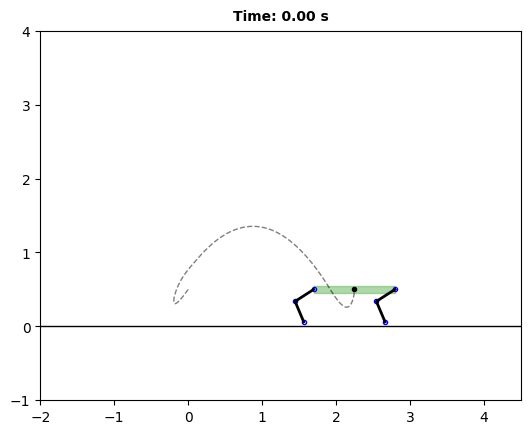

<Figure size 640x480 with 0 Axes>

In [ ]:
# All feet contact phase
ALL_FEET_CONTACT_START = 0
ALL_FEET_CONTACT_END = int(0.3 * N)

# Rear feet contact phase
REAR_FEET_CONTACT_START = ALL_FEET_CONTACT_END
REAR_FEET_CONTACT_END = int(0.4 * N)

# Flight phase
FLIGHT_START = REAR_FEET_CONTACT_END
FLIGHT_END = int(0.75 * N)

# Landing phase
LANDING_START = FLIGHT_END 
LANDING_END = N

for k in range(N - 1):
    
    add_dynamics_constraint(opti, Q, V, U, k, get_next_state)

    # Phase 1 - All feet contact
    if ALL_FEET_CONTACT_START <= k < ALL_FEET_CONTACT_END:
        add_friction_cone_constraint(opti, U, k, mu, "front")
        add_contact_constraint(opti, Q, k, q_initial, "front")

        add_friction_cone_constraint(opti, U, k, mu, "rear")
        add_contact_constraint(opti, Q, k, q_initial, "rear")

    # Phase 2 - Rear feet only
    if REAR_FEET_CONTACT_START <= k < REAR_FEET_CONTACT_END:
        add_zero_force_constraint(opti, U, k, "front")

        add_friction_cone_constraint(opti, U, k, mu, "rear")
        add_contact_constraint(opti, Q, k, q_initial, "rear")

    # Phase 3 - Flight
    if FLIGHT_START <= k < FLIGHT_END:
        add_zero_force_constraint(opti, U, k, "front")

        add_zero_force_constraint(opti, U, k, "rear")

    # Phase 4 - Landing
    if LANDING_START <= k < LANDING_END:
        add_friction_cone_constraint(opti, U, k, mu, "front")
        add_contact_constraint(opti, Q, k, q_final, "front")

        add_friction_cone_constraint(opti, U, k, mu, "rear")
        add_contact_constraint(opti, Q, k, q_final, "rear")


def is_contact(n):
    return n < int(0.35 * N) or n > int(0.65 * N)


cost = 0

# Cost function weights of corresponding elements
JOINT_ANGLE_PENALTY_WEIGHT = 2000
JOINT_VELOCITY_PENALTY_WEIGHT = 500
GRF_PENALTY_WEIGHT = 2
BODY_ORIENTATION_PENALTY_WEIGHT = 1

for k in range(N - 1):
    q_angles = Q[3:, k]
    q_angles_default = q_initial[3:]
    q_angles_diff = q_angles - q_angles_default

    lower_bounds = [-np.pi/2] * 4
    uppder_bounds = [np.pi/2] * 4
    apply_joint_limits(opti, q_angles_diff, lower_bounds, uppder_bounds)

    cost += JOINT_ANGLE_PENALTY_WEIGHT * ca.dot(q_angles_diff, q_angles_diff)
    uext = U[:4, k]
    cost += GRF_PENALTY_WEIGHT * ca.dot(uext, uext)
    uext = U[4:, k]
    cost += JOINT_VELOCITY_PENALTY_WEIGHT  * ca.dot(uext, uext)

    phi = Q[2, k]

    omega = k / N

    cost += BODY_ORIENTATION_PENALTY_WEIGHT * (phi - (q_initial[2] + omega * (q_final[2] - q_initial[2]))) ** 2

opti.minimize(cost)


time = np.linspace(0, N * dt, N)
for i, t in enumerate(time):
    if is_contact(i):
        if i < N - 1:
            opti.set_initial(U[1, i], 0)
            opti.set_initial(U[2, i], 0)
            opti.set_initial(U[3, i], 0)
            opti.set_initial(U[4, i], 0)
    else:
        if i < N - 1:
            opti.set_initial(U[1, i], m * 9.81 / 2)
            opti.set_initial(U[3, i], m * 9.81 / 2)

    omega = i / N
    opti.set_initial(Q[:, i], q_initial + omega * (q_final - q_initial))

opti.solver("ipopt")
sol = opti.solve()

U_sol = sol.value(U)
print(U_sol[:4, :])
print(U_sol[:4, :] >= -1e-4)

Q_sol = sol.value(Q)

visualizer = QuadrupedSimulator(L, leg_length)
visualizer.set_data(Q_sol[:, -1], None, Q_sol[:2, :-1])
plt.show()


def animate(i):
    t = i * dt
    visualizer.set_data(Q_sol[:, i], None if i == N - 1 else U_sol[:, i], Q_sol[:2, :i], time=t)
    return (visualizer.ax,)


anim = animation.FuncAnimation(visualizer.fig, animate, frames=N, interval=50, blit=False)
plt.close()

html = HTML(anim.to_jshtml())
display(html)

if save_gifs:
    anim.save("to_grf.gif")

In [ ]:
# empty :) 